# Bayesian Power Analysis for Synthetic Control

Our addition to `causalpy` is aimed at improving the tool's usefulness for experimenters in the planning and validation stages of quasi-experiments. We have introduced a power analysis method in a Bayesian framework that provides a systematic approach to determine the sensitivity of a model in detecting expected effects. We will explore practical applications, comprehend the underlying principles, and discuss how this approach can improve our decision-making process in selecting models and designing experiments.

This notebook is dedicated to exploring and implementing Bayesian Power Analysis in the context of `causalpy`.

## How it Works
The method involves creating a null model that does not capture any effect during a period where no effect is present. By analyzing the posterior distribution derived from this null model, experimenters can estimate the magnitude of effect necessary for it to be considered significant. This estimation allows for an assessment of the model's sensitivity to changes and the experiment's feasibility.

Our proposed power analysis method is designed to be universally applicable across different regression models in `causalpy` such as **synthetic controls** and **interrupted time series**. By assessing the null model's posterior, we can validate that our regression does not inadvertently capture effects during a control period. This validation process not only aids in determining the required effect size for significance but also helps in evaluating the natural bias of the model, thus ensuring more reliable and accurate experimental planning and analysis.

### Similarities and Differences to Frequentist Methods

Both Bayesian and frequentist methods aim to provide insights into the effectiveness of interventions or treatments. Our power analysis method in the Bayesian context differs from traditional frequentist approaches by focusing on the probability distributions of outcomes instead of point estimates and p-values. Frequentist methods rely on p-values and confidence intervals to reject or fail to reject a null hypothesis. In contrast, Bayesian approaches use the posterior distribution to estimate the probability of various outcomes, providing more nuanced insights into the expected effects and giving the observer the possibility to determine their significance based on the risk of false positives.

## Getting Started

Before diving into the implementation, let's set up our working environment. This setup ensures we have all the necessary tools at our disposal for conducting Bayesian Power Analysis using `causalpy`. 

1. **Installation**: First, we'll install the `causalpy` package, which is essential for our analysis. Simply run `%pip install causalpy` in your Jupyter notebook.

2. **Importing Libraries**: Next, we import key libraries:
   - `causalpy` for statistical modeling and analysis.

3. **Environment Setup**:
   - We use `%load_ext autoreload` and `%autoreload 2` for automatic reloading of modules before executing a new line of code, which is helpful during development.
   - The `seed` variable is set to ensure reproducibility of our results.


In [ ]:
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

seed = 42
pd.set_option('display.precision', 2)

## Loading Data

The dataset is loaded using `causalpy`'s built-in data loading functionality, which provides a suitable dataset for our quasi-experimental design.

Once we've loaded the data, our first step is to identify the point in time where the treatment or intervention is expected to occur. In this case, we've set a specific time (`treatment_time`) to represent when the intervention is expected to take place. Following this, we filter the dataset to exclude any data beyond this treatment time to reflect the pre-intervention period, which aligns with the realistic scenario of not having post-intervention data available during the planning phase of an experiment.

By focusing on the pre-intervention period, we aim to understand the dataset's characteristics and establish a baseline to measure the expected effects of our intervention. This baseline is crucial for determining the magnitude of effect required to be detectable in our framework.

In [3]:
df = cp.load_data("sc")
treatment_time = 70
test_time = 60 #Period before interventation to check the power of your model

In [4]:
power_df = df[:treatment_time].copy()

In [5]:
power_df.info()
power_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   a               70 non-null     float64
 1   b               70 non-null     float64
 2   c               70 non-null     float64
 3   d               70 non-null     float64
 4   e               70 non-null     float64
 5   f               70 non-null     float64
 6   g               70 non-null     float64
 7   counterfactual  70 non-null     float64
 8   causal effect   70 non-null     float64
 9   actual          70 non-null     float64
dtypes: float64(10)
memory usage: 5.6 KB


,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.79,1.28,-0.06,-0.79,1.08,0.82,-2.61,0.14,-0.0,0.40
1,1.84,1.19,-0.22,-1.43,1.08,0.89,-3.11,0.60,-0.0,0.49
2,2.87,1.92,-0.15,-1.43,1.43,1.46,-3.15,1.06,-0.0,1.23
3,2.82,2.42,0.25,-1.26,1.94,2.09,-3.56,1.52,-0.0,1.67
4,3.87,2.36,0.31,-2.39,1.98,2.75,-3.52,1.98,-0.0,1.78


## Creating the Model for Power Analysis

Let's move on to creating our model using the `causalpy` library. Our goal is to predict the period right before the intervention occurs, and to do so, we use a specific time point as a reference for our predictions. The idea is to capture the true nature of the data before any intervention effects come into play.

For our purposes, the Synthetic Control method from `causalpy` fits the bill perfectly. If our model is well-calibrated, we should see the difference between the real data and the estimated inference approach zero, indicating that we have accurately captured the with our method the pre-intervention scenario.

In [6]:
result = cp.pymc_experiments.SyntheticControl(
    power_df,
    test_time,
    formula="actual ~ 0 + a + b + c",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/py

## Evaluating the model

Essentially, if the model accurately represents our reality, and we'll base our decision on the model intervals. By grasping these intervals, we can ascertain how significant an effect must be. In turn, this will allow us to determine the size of the effect that will be considered significant.

In order to ensure that our model isn't overestimating the positive or negative effects, it's important to expect that the errors will be symmetrically distributed around zero. This means that the true and predicted means are aligned. If the model is failing systematically towards either the positive or negative sides, it indicates that it's not accurately capturing the full range of the data.

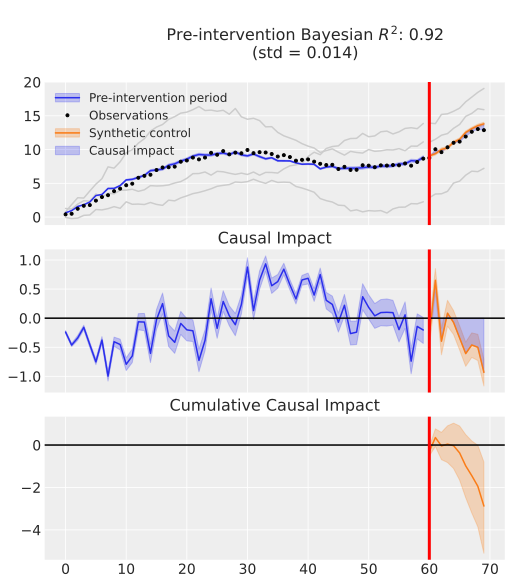

In [7]:
fig, ax = result.plot(plot_predictors=True)

In this case, we can see that the model based on these regressors is systematically failing and although there is still no intervention, it is capturing an effect. But how big is this effect? It seems relevant from the perspective of the images but how to quantify it?

## Power Analysis

We can employ the `power_summary` function to observe the actual cumulative value during the test period and compare it with the projected cumulative outcomes for that same period. Ideally, we should expect errors to be near zero; if they are significantly negative or positive, our model will tend to err consistently in one direction.

Furthermore, we can view the quantiles and determine the minimum detectable effect (MDE) required for the effect to be within those quantiles. Essentially, if your action produces an incremental value that is equal to or greater than the MDE, then your effect will be outside the quantile range and could be considered substantial.

The alpha parameter plays a crucial role in deciding the cumulative confidence interval (CCI). In simple words, the alpha value determines the width of the confidence interval. For instance, if you set an alpha value of `0.1`, it implies that the interval is **90%**. Similarly, an alpha value of `0.05` corresponds to a **95%** interval, and so forth.

In [8]:
alpha=0.1 #

In [9]:
result.power_summary(alpha=alpha)

/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:549: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


,posterior_estimation,results,_systematic_differences,ci,posterior_mde
cumulative,114.31,111.43,-2.87,"[112.430854649129, 116.1599388110477]",1.86
mean,11.43,11.14,-0.29,"[11.2430854649129, 11.61599388110477]",0.19


We could appreciate this better in an image, and for that we can use the `power_plot` function. This would visually display the information presented by `power_summary`.

/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:639: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


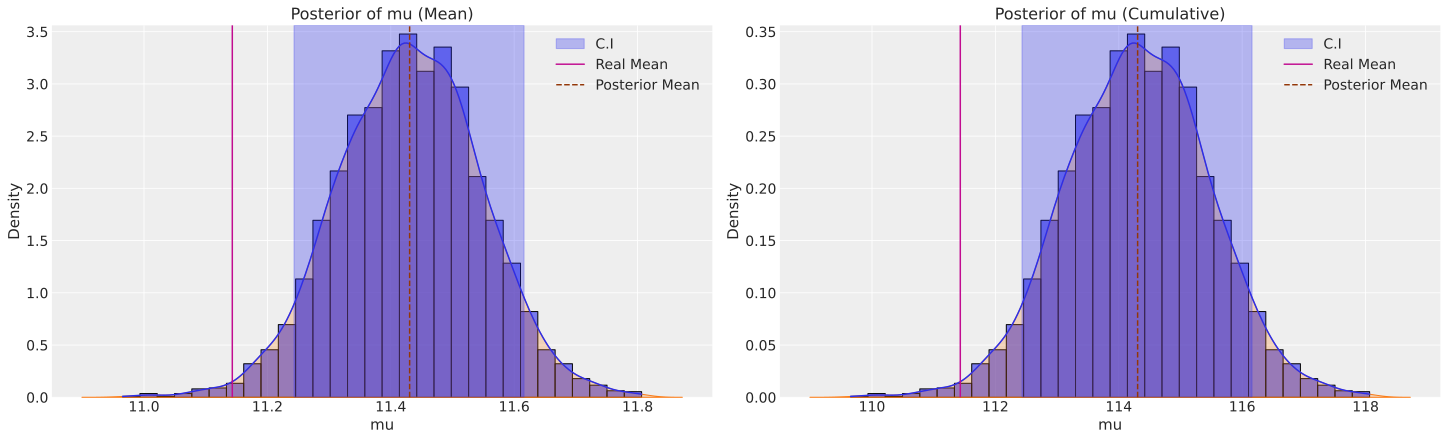

In [10]:
fig, ax = result.plot_power(alpha=alpha)

We can observe that the real mean (solid line) deviates quite a bit from the estimated average and cumulative mean (dashed line) of the intervention period. 

It's evident that the model fails to accurately represent reality. Even during periods without direct actions affecting the target, the actual values significantly deviate from the model's predicted distribution.

:::{note}
It is important to remember that in this methodology, the **power analysis must be executed in a period of the same duration before the intervention** and we have the knowledge that no other action is affecting our target variable (`mu`).

If we do not have pre-intervention data, we cannot make this comparison of the model performance prior to the intervention, losing insight into its power.

Additionally, if during the period prior to the intervention our assumption about other activities affecting the target variable is not maintained, we will not be able to trust the results.
:::

By using the `summary` function and specifying the version, we can generate an output that treats the data as if it were subjected to an intervention. This approach allows for a more comprehensive analysis of the results. In this scenario, the likelihood of our observed value falling within the model's posterior distribution is extremely low. These findings indicate that our model erroneously attributes significance to this particular time frame.

We can observe this after observe the low value of the *Bayesian tail probability*. **How the bayesian tail probability works**? Think of our posterior distribution as a range of possible values that we might see, with the mean value representing the most probable outcome. In this way, we can evaluate the probability of a new value being part of this distribution by measuring how far it deviates from the mean value.

If a value is precisely at the mean, it has a probability of 1 to fall in our posterior. As the value moves away from the average towards both extremes of the distribution, the probability decreases and approaches zero. This process allows us to determine how 'typical' or 'atypical' a new observation is, based on our model estimated posterior. It is an effective tool for interpreting and comprehending the model's inference.

:::{note}
The function shows the values on their regular scale. We are seeing the possible values by our target (´mu´) in every observation or during the whole period.
:::

In [11]:
result.summary(version="intervention", alpha=alpha)

,bayesian_tail_probability,posterior_estimation,results,causal_effect,ci
cumulative,0.01,114.31,111.43,-2.87,"[112.430854649129, 116.1599388110477]"
mean,0.01,11.43,11.14,-0.29,"[11.2430854649129, 11.61599388110477]"


:::{note}
The `summary` function provides insights into both cumulative and average results. Under normal circumstances, it helps in understanding the absolute cumulative and average estimations and effects, along with their respective confidence intervals.
:::

## Update the model

Following the shortcomings of our previous model, we have incorporated new regressors to improve its efficacy. These additional features are instrumental in assessing whether the updated model achieves greater accuracy and precision in mirroring reality. This enhancement is crucial for more accurately estimating experimental outcomes.

In [12]:
result = cp.pymc_experiments.SyntheticControl(
    power_df,
    test_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/p

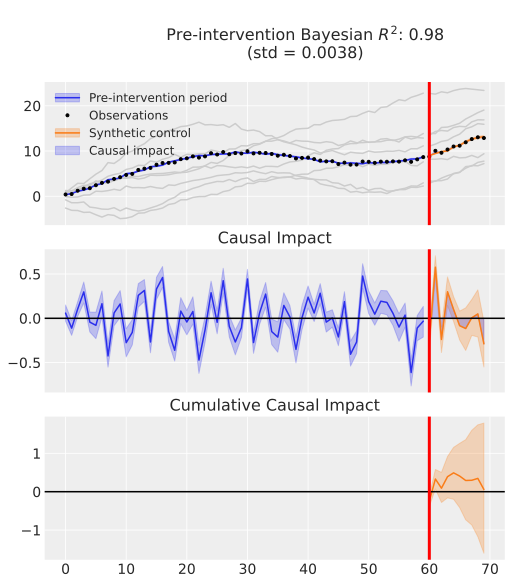

In [13]:
fig, ax = result.plot(plot_predictors=True)

In [14]:
result.power_summary(alpha=alpha)

/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:549: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


,posterior_estimation,results,_systematic_differences,ci,posterior_mde
cumulative,111.37,111.43,5.86e-02,"[109.88865914515354, 112.89282712094747]",1.50
mean,11.14,11.14,5.86e-03,"[10.988865914515353, 11.289282712094748]",0.15


/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:639: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


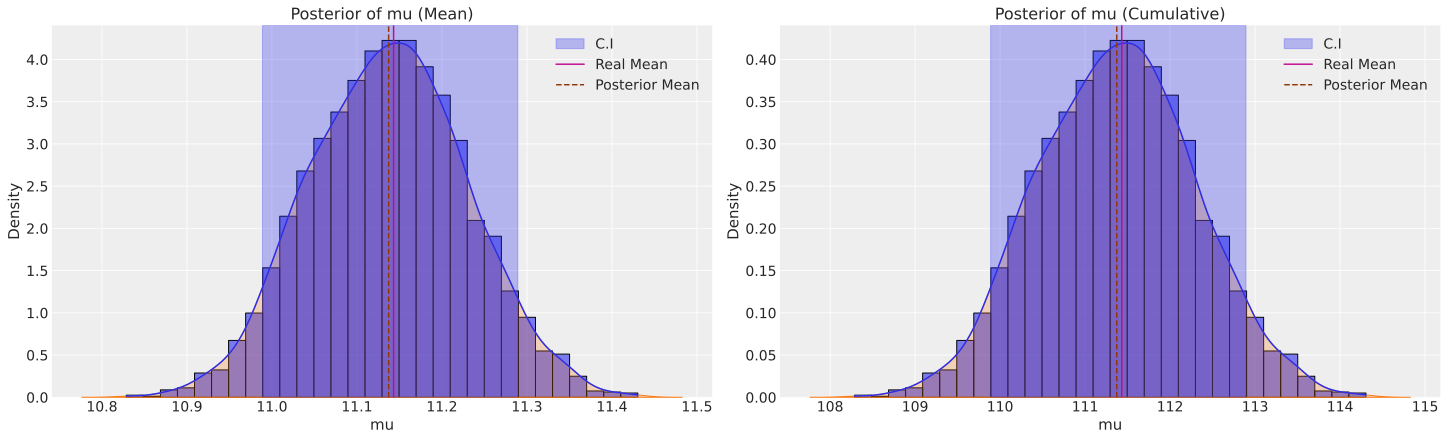

In [15]:
fig, ax = result.plot_power(alpha=alpha)

In [16]:
result.summary(version="intervention", alpha=alpha)

,bayesian_tail_probability,posterior_estimation,results,causal_effect,ci
cumulative,0.95,111.37,111.43,5.86e-02,"[109.88865914515354, 112.89282712094747]"
mean,0.95,11.14,11.14,5.86e-03,"[10.988865914515353, 11.289282712094748]"


This model is outperforming its predecessor significantly. We now observe that the actual value falls within the range estimated by our model. However, there's still a noticeable discrepancy between the estimated total value and the actual one. As previously mentioned, this suggests that we might be overestimating or underestimating certain effects on one side of the distributions.

This becomes apparent when we examine the Bayesian Tail Probability using the `summary` function once more. We now observe a significantly higher value, which is logical. If the actual value is equal to the mean, the probability should be 1. This implies that obtaining that specific value is the most probable outcome according to the posterior distribution.

### Estimation Bias

**Consider this scenario**: If our model exhibits a positive or negative bias, we can recenter our data within the distribution to gauge what the Minimum Detectable Effect (MDE) would be in the absence of this bias. You can apply this bias correction using either the `power_summary` or `power_plot` functions. This adjustment will allow you to observe how the interval of estimation changes.

Essentially, we're implementing a correction to shift our posterior distribution, envisioning a scenario where our model predicts reality with perfect accuracy. This **approach assumes that the same estimation bias present during the model's development will persist throughout the intervention**. While not guaranteed, this is a reasonable assumption, especially considering that the **power test period should closely mirror the actual intervention**, ideally occurring just a few days prior.

In [17]:
power_correction=result.power_summary(alpha=0.1, correction=True)
power_correction

/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:549: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


,posterior_estimation,results,_systematic_differences,ci,posterior_mde
cumulative,111.37,111.43,5.86e-02,"[109.94724463521162, 112.95141261100555]",1.50
mean,11.14,11.14,5.86e-03,"[10.994724463521159, 11.295141261100554]",0.15


/Users/carlos.trujillo/Documents/GitHub/CausalPy/causalpy/pymc_experiments.py:639: UserWarning: The power function is experimental and the API may change in the future.
  warnings.warn(


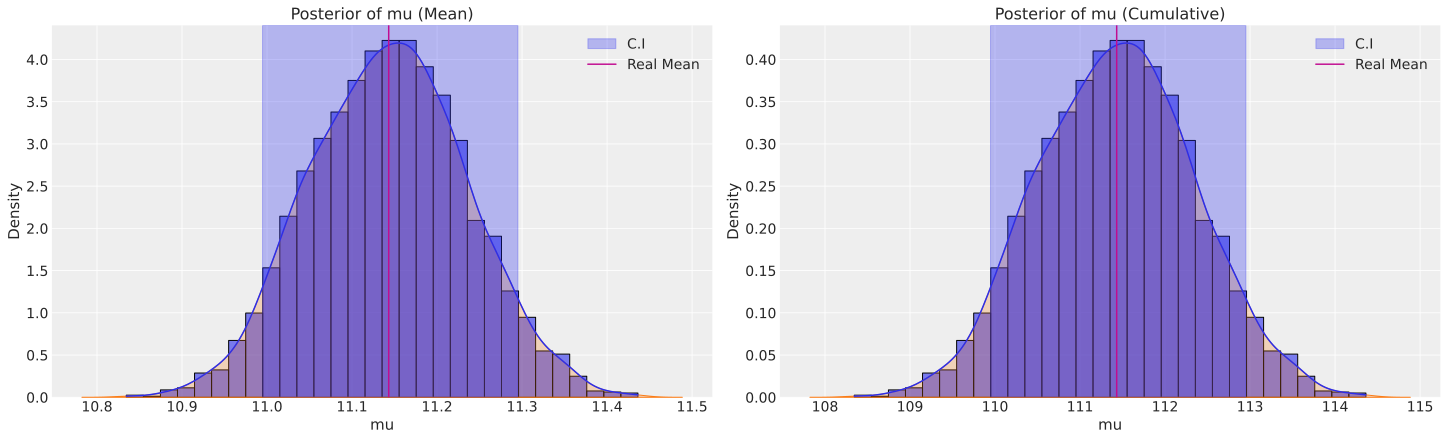

In [18]:
fig, ax = result.plot_power(alpha=0.1, correction=True)

With the recent adjustments, our intervals have shifted to the right, aligning the mean estimation with the actual value. This alignment is why the estimation is not visible on the plot. However, it's crucial to acknowledge the real uncertainty that we should account for. The intervals have moved from a range of (100 - 103) to (101 - 104) at the cumulative distribution, indicating the need for an additional unit on each side.

The MDE remains unchanged because the sigma (standard deviation) is the same for our posterior. However, since the absolute value has shifted, we understand the uncertanty on a model without biases. We should apply this correction during the experimentation period. This adjustment will enable us to observe the probable effect more accurately, devoid of any biases from the model's estimation.

::: {note} 
The `power_summary` function by default use ´correction´ equal ´False´.
:::

## Running our experiment

Having identified which model is most appropriate, we can now proceed with our experiment using the best-suited model. Therefore, we will conduct the experiment during the treatment period, utilizing the complete dataset, now that we have access to all the necessary data.

In [19]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
/Users/carlos.trujillo/anaconda3/envs/CausalPy/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", Fut

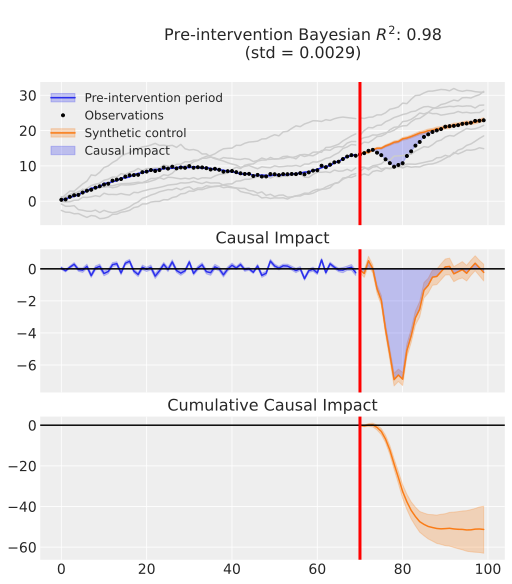

In [20]:
fig, ax = result.plot(plot_predictors=True)

Excellent, the effect is clearly visible, almost unmistakable to the naked eye. While we might not necessarily need statistical analysis to confirm it, it's still prudent to examine the mean and cumulative effect for thoroughness.

We can utilize the summary function once again to gauge the extent to which our actions have influenced the behavior of the target variable.

In [21]:
result.summary(version="intervention", alpha=0.1)

,bayesian_tail_probability,posterior_estimation,results,causal_effect,ci
cumulative,5.84e-03,563.49,512.18,-51.30,"[553.6898523368234, 574.2563747948708]"
mean,5.84e-03,18.78,17.07,-1.71,"[18.456328411227446, 19.141879159829028]"


As anticipated, the total causal effect of our actions during the intervention is approximately `-52.20` units. This indicates a significant impact on our target variable, with a decrease of about `50` units over the entire period.

When broken down to a daily scale, which matches the granularity of our data, it becomes evident that we're experiencing a loss of approximately `-1.74` units daily on our target variable on average due to this action. This result is significant, especially considering how it deviates from the intervals of our posterior distribution.

The minimum expected value was `564.38` cumulatively and `18.81` on average, and we get `512` and `17` respectively. This discrepancy is why our tail probability is very low, suggesting that these results are unlikely to be a part of our posterior distribution.

**Wait a moment!** This could be a biased result, based on our previous power analysis. If the posterior was shifted to the left relative to the real mean in our power analysis, it implies that **we might be UNDERESTIMATING the decrease**. If our actions are indeed reducing the variable, the actual impact could be even more pronounced than we currently estimate.

To address this, let's reapply the parameter correction, this time incorporating the value needed to adjust for the systematic differences observed in the power analysis.

In [29]:
result.summary(
    version="intervention", 
    alpha=0.1, 
    correction=power_correction['_systematic_differences']
)

,bayesian_tail_probability,posterior_estimation,results,causal_effect,ci
cumulative,5.84e-03,563.55,512.18,-51.36,"[553.7484378268815, 574.3149602849289]"
mean,5.84e-03,18.79,17.07,-1.72,"[18.46218696023325, 19.147737708834832]"


It appears that the potential causal effect was `52` as we initially thought. We also notice differences in the intervals, yet this additional value doesn't significantly alter our Bayesian Tail Probability (BTP).

## Conclusion
Power analysis proves to be an invaluable tool in determining the feasibility of an experiment. As we model reality, it guides us in selecting appropriate models and experimenting with those that better interpret reality. Consequently, this enhances our ability to measure the impact of our actions.

However, the application of power analysis still relies on several assumptions, such as:

1. The model's accuracy before the intervention is presumed to remain consistent afterward. Essentially, we assume stable model behavior both pre- and post-intervention.
2. When applying corrections, we assume that systematic errors will persist throughout the intervention period.

Netherless, if we can uphold these assumptions, then we are positioned to:

1. Determine the likely impact of our actions and potentially discard those that may not produce significant changes, addressing them with other types of tests.
2. Choose models based on factors other than R-squared ($R^2$) or Mean Absolute Percentage Error (MAPE).
3. Correct inherent biases in the model, leading to more accurate estimations of effects.